#### Imports

In [0]:
!ls

MURA-v1.1  sample_data


In [0]:
# -*- coding: utf-8 -*-
#!wget -c https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
#!unzip MURA-v1.1.zip
#!rm MURA-v1.1.zip
!ls

In [0]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import keras
pd.options.display.max_colwidth = 100
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.preprocessing import image
from keras.applications.mobilenetv2 import preprocess_input
from keras.applications import MobileNet
from keras.callbacks import (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard)
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.metrics import binary_accuracy, binary_crossentropy
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenetv2 import MobileNetV2
from keras.preprocessing import image as k_im_prep
from keras.models import Model
from keras import backend as K
from keras.models import Sequential

#### Training Data

**output is list of paths to images and list of corresponding labels**

In [0]:
#did this because it gave an error at sample  5307 or near it if took all
sample_e=5307
sample_s2=5339

**TODO: handle that unread sample problem**
If couldn't handle it then see how many labels are +ve and how are -ve to have intuition about model results , maybe because too many samples of one class and little of other

In [0]:
#make dataframe
studies=pd.read_csv('MURA-v1.1/train_labeled_studies.csv', sep=',',header=None)
#making a list of paths and a corresponding list of labels
#using non vectorized for speed
#wrist studies
wrist_tr=studies[studies[0].str.contains("WRIST")==True]
wrist_tr=np.array(wrist_tr)

#making a list of paths and a corresponding list of labels
#using non vectorized for speed
wrist_paths_tr=[]
wrist_labels_tr=[]
for i in tqdm( range(wrist_tr.shape[0]) ):
    study_path=wrist_tr[i][0]
    study_label=wrist_tr[i][1]
    study_files = [f for f in listdir(study_path) if isfile(join(study_path, f))]
    for image in study_files:
        wrist_paths_tr.append(study_path + image)
        wrist_labels_tr.append(study_label)

wrist_paths_tr=np.array(wrist_paths_tr)
wrist_labels_tr=np.array(wrist_labels_tr)

print("\n\n")
print(wrist_paths_tr.shape)
print(wrist_labels_tr.shape)










  0%|          | 0/3460 [00:00<?, ?it/s]







 59%|█████▊    | 2026/3460 [00:00<00:00, 20257.56it/s]







100%|██████████| 3460/3460 [00:00<00:00, 19404.96it/s]




(9756,)
(9756,)


### Todo : issue , images after preprocessing look different

read images from paths to array of images

In [0]:
wrist_images_tr=[]
for path in tqdm(wrist_paths_tr[:sample_e]):
    wrist=k_im_prep.load_img(path, target_size=(224, 224))
    wrist_images_tr.append(np.array(wrist))
#new start
for path in tqdm(wrist_paths_tr[sample_s2:]):
    wrist=k_im_prep.load_img(path, target_size=(224, 224))
    wrist_images_tr.append(np.array(wrist))
#making it a numpy array instead of python list
wrist_images_tr=np.array(wrist_images_tr)

#wrist_labels_tr=wrist_labels_tr[:sample_e]
print("\n\n")
print(wrist_images_tr.shape)
print(wrist_labels_tr.shape)









  0%|          | 0/5307 [00:00<?, ?it/s]







  0%|          | 24/5307 [00:00<00:22, 233.04it/s]







  1%|          | 51/5307 [00:00<00:21, 241.04it/s]







  2%|▏         | 80/5307 [00:00<00:20, 253.71it/s]







  2%|▏         | 103/5307 [00:00<00:21, 243.51it/s]







  2%|▏         | 124/5307 [00:00<00:22, 230.84it/s]







  3%|▎         | 147/5307 [00:00<00:22, 229.87it/s]







  3%|▎         | 170/5307 [00:00<00:22, 227.00it/s]







  4%|▍         | 204/5307 [00:00<00:20, 250.59it/s]







  4%|▍         | 229/5307 [00:00<00:21, 232.59it/s]







  5%|▍         | 256/5307 [00:01<00:20, 242.53it/s]







  5%|▌         | 290/5307 [00:01<00:19, 264.04it/s]







  6%|▌         | 318/5307 [00:01<00:18, 263.35it/s]







  7%|▋         | 345/5307 [00:01<00:19, 260.49it/s]







  7%|▋         | 373/5307 [00:01<00:18, 264.75it/s]







  8%|▊         | 400/5307 [00:01<00:20, 234.89it/s]







  8%|▊         | 431/5307 [00:01<00:19, 250.62it/s]







  9




(9724, 224, 224, 3)
(9756,)


In [0]:
start=wrist_labels_tr[:sample_e]
end=wrist_labels_tr[sample_s2:]
wrist_labels_tr=np.hstack([  start, end  ])



(9724,)
9724


In [0]:
print("\n")
print(wrist_images_tr.shape)
print(wrist_labels_tr.shape)
print(start.shape[0]+end.shape[0])



(9724, 224, 224, 3)
(9724,)
9724


1


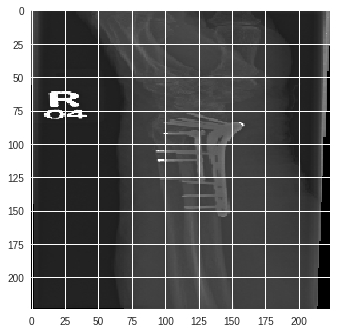

In [0]:
#visualizing random sample after preprocesiing 
index=999
plt.imshow(wrist_images_tr[index])
print(wrist_labels_tr[index])

#### Validation Data

In [0]:
#make dataframe
studies=pd.read_csv('MURA-v1.1/valid_labeled_studies.csv', sep=',',header=None)
#making a list of paths and a corresponding list of labels
#using non vectorized for speed
#wrist studies
wrist_val=studies[studies[0].str.contains("WRIST")==True]
wrist_val=np.array(wrist_val)

#making a list of paths and a corresponding list of labels
#using non vectorized for speed
wrist_paths_val=[]
wrist_labels_val=[]
for i in tqdm( range(wrist_val.shape[0]) ):
    study_path=wrist_val[i][0]
    study_label=wrist_val[i][1]
    study_files = [f for f in listdir(study_path) if isfile(join(study_path, f))]
    for image in study_files:
        wrist_paths_val.append(study_path + image)
        wrist_labels_val.append(study_label)

wrist_paths_val=np.array(wrist_paths_val)
wrist_labels_val=np.array(wrist_labels_val)

wrist_images_val=[]
for path in tqdm(wrist_paths_val):
    wrist=k_im_prep.load_img(path, target_size=(224, 224))
    wrist_images_val.append(np.array(wrist))

wrist_images_val=np.array(wrist_images_val)

print(wrist_images_val.shape)












  0%|          | 0/237 [00:00<?, ?it/s]







100%|██████████| 237/237 [00:00<00:00, 13941.80it/s]







  0%|          | 0/659 [00:00<?, ?it/s]







  3%|▎         | 22/659 [00:00<00:02, 218.63it/s]







  7%|▋         | 48/659 [00:00<00:02, 227.88it/s]







 10%|█         | 67/659 [00:00<00:02, 214.06it/s]







 14%|█▎        | 90/659 [00:00<00:02, 217.75it/s]







 17%|█▋        | 110/659 [00:00<00:02, 211.09it/s]







 20%|█▉        | 130/659 [00:00<00:02, 205.01it/s]







 23%|██▎       | 151/659 [00:00<00:02, 203.62it/s]







 27%|██▋       | 177/659 [00:00<00:02, 215.70it/s]







 32%|███▏      | 209/659 [00:00<00:01, 238.49it/s]







 35%|███▌      | 233/659 [00:01<00:01, 234.87it/s]







 39%|███▉      | 257/659 [00:01<00:01, 235.31it/s]







 43%|████▎     | 283/659 [00:01<00:01, 239.91it/s]







 47%|████▋     | 308/659 [00:01<00:01, 237.40it/s]







 50%|█████     | 332/659 [00:01<00:01, 234.61it/s]







 54%|█████▍    | 356/659 [00:0

(659, 224, 224, 3)


label=  0


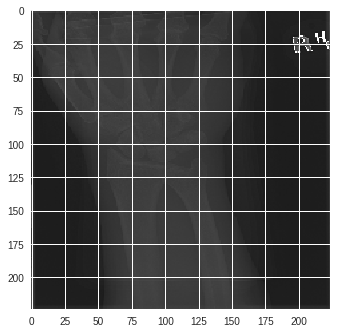

In [0]:
#visualizing random sample
index=650
plt.imshow(wrist_images_val[index])
print("label= ",wrist_labels_val[index])

In [0]:
#data bias : train
print("0 normal, 1 abnormal")
unique, counts = np.unique(wrist_labels_tr, return_counts=True)
print(dict(zip(unique, counts)))
#val
unique, counts = np.unique(wrist_labels_val, return_counts=True)
print(dict(zip(unique, counts)))


0 normal, 1 abnormal
{0: 5737, 1: 3987}
{0: 364, 1: 295}


### Model

#### TODO : see if want to freeze less layers

In [0]:
MobileNetV2_model = MobileNetV2(input_shape= (224, 224, 3),weights='imagenet', include_top=False)
for layer in MobileNetV2_model.layers:
  layer.trainable= False 
#MobileNetV2_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_18[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

#### TODO
* could we add precision or recall metric ? change accuracy?
* why doesn't it work if removed GlobalAveragePooling line?
* 

In [0]:
# This returns a tensor
inputs = Input(shape=(224,224,3))

# a layer instance is callable on a tensor, and returns a tensor
x = MobileNetV2_model(inputs)
# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_14  (None, 1280)              0         
_________________________________________________________________
dense_67 (Dense)             (None, 512)               655872    
_________________________________________________________________
dense_68 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_69 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 33        
Total para

In [0]:
model.fit(wrist_images_tr, wrist_labels_tr, epochs=5, validation_data=(wrist_images_val, wrist_labels_val), shuffle=True, verbose=1 )  # starts training
#TODO: add class_weight parameter dictionary of weights to each class index

Train on 9724 samples, validate on 659 samples
Epoch 1/5
9724/9724 [==============================] - 98s 10ms/step - loss: 9.4057 - acc: 0.4100 - val_loss: 8.8058 - val_acc: 0.4476
Epoch 2/5
9724/9724 [==============================] - 37s 4ms/step - loss: 9.4057 - acc: 0.4100 - val_loss: 8.8058 - val_acc: 0.4476
Epoch 3/5
9724/9724 [==============================] - 37s 4ms/step - loss: 9.4057 - acc: 0.4100 - val_loss: 8.8058 - val_acc: 0.4476
Epoch 4/5
9724/9724 [==============================] - 37s 4ms/step - loss: 9.4057 - acc: 0.4100 - val_loss: 8.8058 - val_acc: 0.4476
Epoch 5/5
9724/9724 [==============================] - 37s 4ms/step - loss: 9.4057 - acc: 0.4100 - val_loss: 8.8058 - val_acc: 0.4476


**Trying Densnet**

In [0]:
#initializing pretrained model
DenseNet169_model = DenseNet169(input_shape= (224, 224, 3),weights='imagenet', include_top=False)
#freeze layers of densenet
for layer in DenseNet169_model.layers:
  layer.trainable= False 
#DenseNet169_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           input_20[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [0]:
#Bone Model

# This returns a tensor
inputs = Input(shape=(224,224,3))

# a layer instance is callable on a tensor, and returns a tensor
x = DenseNet169_model(inputs)
# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
densenet169 (Model)          (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_15  (None, 1664)              0         
_________________________________________________________________
dense_71 (Dense)             (None, 512)               852480    
_________________________________________________________________
dense_72 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_73 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 33        
Total para

In [0]:
#Y=keras.utils.to_categorical(wrist_labels_tr, num_classes=2)
model.fit(wrist_images_tr,wrist_labels_tr  , epochs=5, validation_data=(wrist_images_val, wrist_labels_val), shuffle=True, verbose=1 )  # starts training
#TODO: add class_weight parameter dictionary of weights to each class index

Train on 9724 samples, validate on 659 samples
Epoch 1/5
9724/9724 [==============================] - 186s 19ms/step - loss: 0.5492 - acc: 0.7210 - val_loss: 2.8453 - val_acc: 0.5524
Epoch 2/5
9724/9724 [==============================] - 99s 10ms/step - loss: 0.4908 - acc: 0.7623 - val_loss: 4.2843 - val_acc: 0.5524
Epoch 3/5
9724/9724 [==============================] - 100s 10ms/step - loss: 0.4700 - acc: 0.7784 - val_loss: 3.3059 - val_acc: 0.5508
Epoch 4/5
9724/9724 [==============================] - 99s 10ms/step - loss: 0.4536 - acc: 0.7854 - val_loss: 4.2098 - val_acc: 0.5524
Epoch 5/5
9724/9724 [==============================] - 99s 10ms/step - loss: 0.4406 - acc: 0.7938 - val_loss: 4.6775 - val_acc: 0.5524


**Inception code from Keras docs**
https://keras.io/applications/

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(32, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False


In [0]:
model.summary()

In [0]:

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='binary_crossentropy',
              metrics=['binary_accuracy'])
#Y=keras.utils.to_categorical(wrist_labels_tr, num_classes=2)
# train the model on the new data for a few epochs
model.fit(wrist_images_tr, wrist_labels_tr, epochs=5, validation_data=(wrist_images_val, wrist_labels_val), shuffle=True, verbose=1 )


In [0]:
print(Y.shape)

In [0]:
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(wrist_images_tr, wrist_labels_tr, epochs=5, validation_data=(wrist_images_val, wrist_labels_val), shuffle=True, verbose=1 )

In [0]:
loss,accuracy=model.evaluate(x=wrist_images_tr, y=wrist_labels_tr, batch_size=128, verbose=1)
print("train loss",loss,"train accuracy",accuracy)

In [0]:
loss,accuracy=model.evaluate(x=wrist_images_val, y=wrist_labels_val, batch_size=128, verbose=1)
print("validation loss",loss,"validation accuracy",accuracy)

In [0]:
def make_FT_model(base=1, imagenet=True, freeze_all=True, add_denses=True):
  
  #weights of pretrained model
  if (imagenet=True):
    w='imagenet'
  else:
    w=None
  
  #initializing pretrained model
  if (base==0):
    base_model=MobileNetV2(input_shape= (224, 224, 3),weights=w, include_top=False)
  elif (base == 1):
    base_model = DenseNet169(input_shape= (224, 224, 3),weights=w, include_top=False)
  elif (base == 2):
    base_model = InceptionV3(input_shape= (224, 224, 3),weights=w, include_top=False)
 
  if (freeze_all):
    #freeze layers of densenet
    for layer in base_model.layers:
      layer.trainable= False 
  
  # add a global spatial average pooling layer
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  
  if(add_denses):
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(1, activation='sigmoid')(x)
    return predictions
  else:
    return x

** Current point: generalizing functions and code cleaning+ seeing early stopping callback**

All unsolved problems:
* why is it in every epoch the result is the same, all results exactly the same
* which layers to freeze and which to train + should I train TL before freezing it ?
* data augmentation to generate more data
* recording variation in accuracy after every change to get intuition
* no matter Mobilenet,densenet, added or removed denses same results !! exact same even fractions
* the fear of overfitting over validation set
* what does outputted loss represent ? how to read the number ?
* Get more training data through solving the reading problem and getting the remaining 4k images
* normalization step and its effect on accuracy
* should I use 1 or two neurons at output layer ?
* binary crossentropy weights
* justifying parameter use and discovering useful params